<a href="https://colab.research.google.com/github/dmar10862/uoc_tipologia_y_ciclo_de_vida_de_los_datos_practica_2/blob/develop/src/UOC_M2851_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Practica 2: Limpieza y análisis de datos**

M2851 - Tipología y ciclo de vida de los datos

Ciencia de Datos

**David Marín Sánchez**

Junio 2020

**Kaggle Competition**

[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview)

# Librerias y funciones

https://github.com/Kaggle/kaggle-api

In [0]:
from google.colab import drive
from google.colab import auth
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Input, Embedding, LSTM, Masking, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [6]:
# Montar Google Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%bash
pip install -q kaggle

In [9]:
# Cargar las credeciales de Kaggle
%%bash
cp -a "/content/drive/My Drive/Credentials/kaggle.json" /root/.kaggle
ls -l /root/.kaggle

total 4
-rw------- 1 root root 64 May  9 08:42 kaggle.json


In [14]:
# Descargar dataset
%%bash
mkdir -p datasets
cd datasets
kaggle competitions download -c titanic
ls -la datasets

100%|##########| 28.0k/28.0k [00:00<00:00, 43.4MB/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 3.32MB/s]
100%|##########| 59.8k/59.8k [00:00<00:00, 61.1MB/s]


# Cargar Datos

In [257]:
# Cargar dataset como Pandas DataFrame
df_train_orig = pd.read_csv('datasets/train.csv') 
df_train = df_train_orig.copy()
display(df_train.shape)
display(df_train.head())

(891, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [258]:
# Cargar dataset de test
X_test_orig = pd.read_csv('datasets/test.csv') 
X_test = X_test_orig.copy()
display(X_test.shape)
display(X_test.head())

(418, 11)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Limpieza de datos

In [0]:
# Deajar solo variables útiles
df_train = df_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
X_test = X_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [260]:
display(df_train.describe())

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [261]:
# Convertir variables en numéricas
df_train['Sex'], sex = pd.factorize(df_train['Sex'])
df_train['Embarked'], embarked = pd.factorize(df_train['Embarked'])
display(df_train.head())
print(sex)
print(embarked)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


Index(['male', 'female'], dtype='object')
Index(['S', 'C', 'Q'], dtype='object')


In [262]:
display(df_train.describe())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.359147
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.638707
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


In [263]:
# Convertir variables en numéricas
X_test['Sex'], sex = pd.factorize(X_test['Sex'])
X_test['Embarked'], embarked = pd.factorize(X_test['Embarked'])
display(X_test.head())
print(sex)
print(embarked)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,0
1,3,1,47.0,1,0,7.0000,1
2,2,0,62.0,0,0,9.6875,0
3,3,0,27.0,0,0,8.6625,1
4,3,1,22.0,1,1,12.2875,1


Index(['male', 'female'], dtype='object')
Index(['Q', 'S', 'C'], dtype='object')


In [264]:
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000
mean,2.265550,0.363636,30.272590,0.447368,0.392344,35.627188,1.133971
std,0.841838,0.481622,14.181209,0.896760,0.981429,55.907576,0.580452
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,21.000000,0.000000,0.000000,7.895800,1.000000
50%,3.000000,0.000000,27.000000,0.000000,0.000000,14.454200,1.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.500000,1.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000


# Valores perdidos

In [265]:
# https://scikit-learn.org/stable/modules/impute.html
# https://scikit-learn.org/dev/modules/generated/sklearn.impute.KNNImputer.html

# Se asigna a la variable imp un objeto del tipo KNNImputer
imp = KNNImputer()

# Se aplica la transformación para cada atributo
df_train['Age'] = pd.DataFrame(imp.fit_transform(df_train[['Age']]), columns = ['Age'])

# Se analiza la distribución del dataframe
display(df_train.describe())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.359147
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.638707
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


In [266]:
# https://scikit-learn.org/stable/modules/impute.html
# https://scikit-learn.org/dev/modules/generated/sklearn.impute.KNNImputer.html

# Se asigna a la variable imp un objeto del tipo KNNImputer
imp = KNNImputer()

# Se aplica la transformación para cada atributo
X_test['Age'] = pd.DataFrame(imp.fit_transform(X_test[['Age']]), columns = ['Age'])

# Se analiza la distribución del dataframe
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,418.000000,418.000000,418.000000,417.000000,418.000000
mean,2.265550,0.363636,30.272590,0.447368,0.392344,35.627188,1.133971
std,0.841838,0.481622,12.634534,0.896760,0.981429,55.907576,0.580452
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800,1.000000
50%,3.000000,0.000000,30.272590,0.000000,0.000000,14.454200,1.000000
75%,3.000000,1.000000,35.750000,1.000000,0.000000,31.500000,1.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000


# Estandarización

In [0]:
df_train = pd.DataFrame(StandardScaler().fit_transform(df_train), 
                        columns = df_train.columns)

In [268]:
display(df_train.describe())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,-2.287732e-16,-2.031048e-16,3.162453e-16,2.562796e-16,3.456519e-16,6.716164e-17,-4.373606e-17,1.171279e-16
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-7.892723e-01,-1.566107e+00,-7.376951e-01,-2.253155e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,-2.129160e+00
25%,-7.892723e-01,-3.693648e-01,-7.376951e-01,-5.924806e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,-5.626187e-01
50%,-7.892723e-01,8.273772e-01,-7.376951e-01,0.000000e+00,-4.745452e-01,-4.736736e-01,-3.573909e-01,-5.626187e-01
75%,1.266990e+00,8.273772e-01,1.355574e+00,4.079260e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,1.003923e+00
max,1.266990e+00,8.273772e-01,1.355574e+00,3.870872e+00,6.784163e+00,6.974147e+00,9.667167e+00,2.570464e+00


In [0]:
X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), 
                        columns = X_test.columns)

In [270]:
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.170000e+02,4.180000e+02
mean,-2.018587e-17,-1.859225e-17,1.328018e-17,-1.593622e-17,-1.407699e-16,-5.258251e-17,8.499315e-18
std,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00,1.001201e+00,1.001198e+00
min,-1.505120e+00,-7.559289e-01,-2.385419e+00,-4.994700e-01,-4.002477e-01,-6.380170e-01,-1.955941e+00
25%,-1.505120e+00,-7.559289e-01,-5.763018e-01,-4.994700e-01,-4.002477e-01,-4.966178e-01,-2.310816e-01
50%,8.734819e-01,-7.559289e-01,0.000000e+00,-4.994700e-01,-4.002477e-01,-3.791690e-01,-2.310816e-01
75%,8.734819e-01,1.322876e+00,4.340463e-01,6.169924e-01,-4.002477e-01,-7.391031e-02,-2.310816e-01
max,8.734819e-01,1.322876e+00,3.623577e+00,8.432229e+00,8.781044e+00,8.536851e+00,1.493778e+00


# Análisis de normalidad y homogeneidad de la varianza y valores extremos

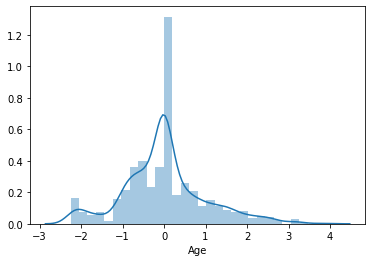

In [271]:
# Age
plot = sns.distplot(df_train['Age']);

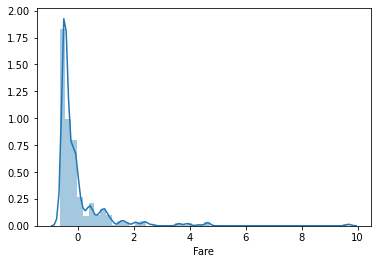

In [272]:
plot = sns.distplot(df_train['Fare']);

# Análisis de correlación

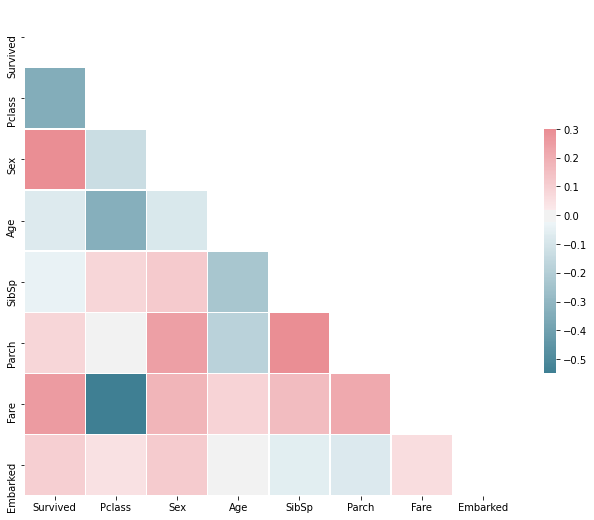

In [273]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

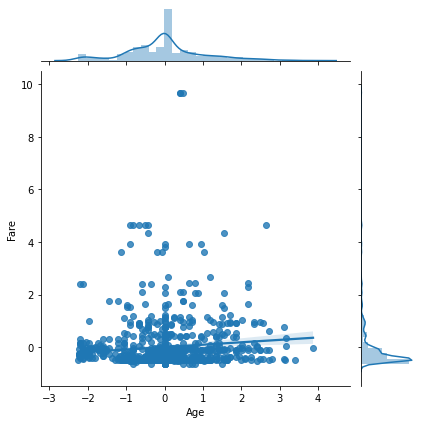

In [274]:
# https://seaborn.pydata.org/tutorial/regression.html
sns.jointplot(x="Age", y="Fare", kind="reg", data=df_train);

# Modelado

In [0]:
# Preparar datos para ML
def split_train_validation(X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
  return X_train, y_train, X_val, y_val

In [0]:
# ML Model train
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
def train_ml_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=1, patience=0, shuffle=True, stateful=False):
  if stateful:
    # fit model
    for i in range(epochs):
      model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1, batch_size=batch_size, verbose=1, shuffle=shuffle)
      model.reset_states()

    # Estimate model performance
    trainScore = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    model.reset_states()
    valScore = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
    model.reset_states()

  else:
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    tb = TensorBoard("/tmp/TensorBoard/keras")

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=shuffle, callbacks=[es, mc, tb])

    # load the saved model
    model = load_model('best_model.h5')

    # plot training history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
  
    # Estimate model performance
    trainScore = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    valScore = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
  
  print('Train MSE: %.3f' % trainScore)
  print('Validation MSE: %.3f' % valScore)
  
  return model

In [0]:
# Red neuronal densa
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# @tf.function
def dense_nn(X, y, epochs=200, batch_size=1, loss='mse', lr=0.0001, patience=10, shuffle=True, stateful=False):
  
  X_train, y_train, X_val, y_val = split_train_validation(X, y)

  n_input =  X_train.shape[1]
  n_output = y_train.shape[1]
  
  model = Sequential([
      Dense(n_input, input_dim=n_input, activation='relu'),
      Dense(60, activation='sigmoid'),
      Dense(n_output)
  ])
  
  optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(loss=loss, optimizer=optimizer)
  
  model = train_ml_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience, shuffle, stateful)
  
  return model

In [0]:
# ML Model predict
def predict_with_ml_model(model, X_test, batch_size=1, stateful=False):
  y_pred = model.predict(X_test, batch_size=batch_size)
  if stateful:
    model.reset_states()

  predictions = []
  for pred in y_pred:
    if pred > 0:
      predictions.append(1)
    else:
      predictions.append(0)
      
  return predictions

In [279]:
X = df_train.drop(columns=['Survived'])
display(X.head())
print(X.shape)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.827377,-0.737695,-0.592481,0.432793,-0.473674,-0.502445,-0.562619
1,-1.566107,1.355574,0.638789,0.432793,-0.473674,0.786845,1.003923
2,0.827377,1.355574,-0.284663,-0.474545,-0.473674,-0.488854,-0.562619
3,-1.566107,1.355574,0.407926,0.432793,-0.473674,0.420730,-0.562619
4,0.827377,-0.737695,0.407926,-0.474545,-0.473674,-0.486337,-0.562619


(891, 7)


In [280]:
y = df_train[['Survived']]
display(y.head())
print(y.shape)

,Survived
0,-0.789272
1,1.266990
2,1.266990
3,1.266990
4,-0.789272


(891, 1)


Epoch 1/200
712/712 [==============================] - 1s 2ms/step - loss: 0.9551 - val_loss: 0.9641
Epoch 2/200
712/712 [==============================] - 1s 1ms/step - loss: 0.8876 - val_loss: 0.9241
Epoch 3/200
712/712 [==============================] - 1s 2ms/step - loss: 0.8400 - val_loss: 0.8760
Epoch 4/200
712/712 [==============================] - 1s 2ms/step - loss: 0.7931 - val_loss: 0.8396
Epoch 5/200
712/712 [==============================] - 1s 2ms/step - loss: 0.7484 - val_loss: 0.8055
Epoch 6/200
712/712 [==============================] - 1s 2ms/step - loss: 0.7108 - val_loss: 0.7768
Epoch 7/200
712/712 [==============================] - 1s 2ms/step - loss: 0.6780 - val_loss: 0.7560
Epoch 8/200
712/712 [==============================] - 1s 1ms/step - loss: 0.6548 - val_loss: 0.7528
Epoch 9/200
712/712 [==============================] - 1s 1ms/step - loss: 0.6367 - val_loss: 0.7463
Epoch 10/200
712/712 [==============================] - 1s 1ms/step - loss: 0.6261 - val_lo

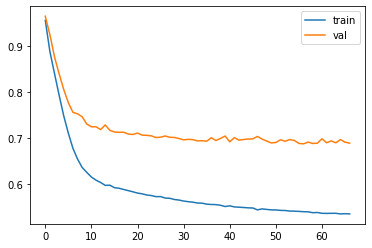

Train MSE: 0.541
Validation MSE: 0.688


In [306]:
model = dense_nn(X, y, epochs=200, lr=0.0001, patience=10)

In [307]:
# generate predictions for test
df_pred = X_test_orig.copy()
df_pred = df_pred[['PassengerId']]
df_pred['Survived'] = predict_with_ml_model(model, X_test)
  
display(df_pred.head())
df_pred.to_csv('submission.csv', index=False)  

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [294]:
%%bash
kaggle competitions submit -c titanic -f submission.csv -m "New submission test"

Successfully submitted to Titanic: Machine Learning from Disaster

100%|##########| 2.77k/2.77k [00:03<00:00, 854B/s]
